In [56]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
df = pd.read_csv('Cleaned_Economic_News_Relabeled.csv', encoding='ISO-8859-1')
df_cleaned = df.dropna(subset=['headline', 'sentiment'])
df_cleaned = df_cleaned[df_cleaned['headline'].str.strip().astype(bool)]

def categorize_sentiment(positivity):
    if positivity == -1:
        return 'negative'
    elif positivity == 0:
        return 'neutral'
    elif positivity == 1:
        return 'positive'
    else:
        return None

df_cleaned['sentiment'] = df_cleaned['sentiment'].apply(categorize_sentiment)

In [58]:
def preprocess_headline(headline):
    headline = headline.lower()
    headline = re.sub(r'\b\d+(\.\d+)?\b', '<NUMBER>', headline)
    headline = re.sub(r'\d+(\.\d+)?%', '<PERCENTAGE>', headline)
    headline = re.sub(r'\$\d+(\.\d+)?', '<CURRENCY>', headline)
    headline = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '<DATE>', headline)
    headline = re.sub(r'[^\w\s\.,!?\'":;()-]', '', headline)
    headline = re.sub(r'\s+', ' ', headline).strip()
    return headline

df_cleaned['cleaned_headline'] = df_cleaned['headline'].apply(preprocess_headline)

In [59]:
class_counts = df_cleaned['sentiment'].value_counts()
target_count = class_counts.min()

df_negative = df_cleaned[df_cleaned['sentiment'] == 'negative'].sample(target_count, random_state=42)
df_neutral = df_cleaned[df_cleaned['sentiment'] == 'neutral'].sample(target_count, random_state=42)
df_positive = df_cleaned[df_cleaned['sentiment'] == 'positive'].sample(target_count, random_state=42)

df_balanced = pd.concat([df_negative, df_neutral, df_positive]).sample(frac=1, random_state=42).reset_index(drop=True)


X = df_balanced['cleaned_headline']  
y = df_balanced['sentiment']  

In [60]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [61]:
# the options for parameters
max_features_options = [5000, 10000, 20000]
ngram_range_options = [(1, 1), (1, 2), (1, 3)]
C_values = [0.1, 1, 10]


In [62]:
#checking hyperparameters
results = []

for max_features in max_features_options:
    for ngram_range in ngram_range_options:
        for C in C_values:
            print(f"Testing max_features={max_features}, ngram_range={ngram_range}, C={C}")
            
            vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words='english')
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            
            model = LogisticRegression(max_iter=5000, random_state=42, C=C)
            model.fit(X_train_tfidf, y_train)
            y_pred = model.predict(X_test_tfidf)
            
            acc = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {acc}\n")
            
            results.append({
                'max_features': max_features,
                'ngram_range': ngram_range,
                'C': C,
                'accuracy': acc
            })

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)
results_df.sort_values(by='accuracy', ascending=False, inplace=True)

Testing max_features=5000, ngram_range=(1, 1), C=0.1
Accuracy: 0.545816733067729

Testing max_features=5000, ngram_range=(1, 1), C=1
Accuracy: 0.5179282868525896

Testing max_features=5000, ngram_range=(1, 1), C=10
Accuracy: 0.50199203187251

Testing max_features=5000, ngram_range=(1, 2), C=0.1
Accuracy: 0.545816733067729

Testing max_features=5000, ngram_range=(1, 2), C=1
Accuracy: 0.5378486055776892

Testing max_features=5000, ngram_range=(1, 2), C=10
Accuracy: 0.5179282868525896

Testing max_features=5000, ngram_range=(1, 3), C=0.1
Accuracy: 0.5338645418326693

Testing max_features=5000, ngram_range=(1, 3), C=1
Accuracy: 0.5338645418326693

Testing max_features=5000, ngram_range=(1, 3), C=10
Accuracy: 0.5258964143426295

Testing max_features=10000, ngram_range=(1, 1), C=0.1
Accuracy: 0.545816733067729

Testing max_features=10000, ngram_range=(1, 1), C=1
Accuracy: 0.5179282868525896

Testing max_features=10000, ngram_range=(1, 1), C=10
Accuracy: 0.50199203187251

Testing max_features

In [63]:
print("Top Hyperparameter Results:")
print(results_df.head())
best_params = results_df.iloc[0]
print("Best Parameters:", best_params)

Top Hyperparameter Results:
    max_features ngram_range    C  accuracy
21         20000      (1, 2)  0.1  0.553785
12         10000      (1, 2)  0.1  0.553785
0           5000      (1, 1)  0.1  0.545817
15         10000      (1, 3)  0.1  0.545817
3           5000      (1, 2)  0.1  0.545817
Best Parameters: max_features       20000
ngram_range       (1, 2)
C                    0.1
accuracy        0.553785
Name: 21, dtype: object


In [64]:
#found tfidfvectorizer to be better than word2vec
vectorizer = TfidfVectorizer(max_features=int(best_params['max_features']), 
                             ngram_range=best_params['ngram_range'], 
                             stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [65]:
model = LogisticRegression(max_iter=5000, random_state=42)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=5000, random_state=42)

In [66]:
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))



Overall Metrics:
Accuracy: 0.5259
Precision: 0.5473
Recall: 0.5259
F1 Score: 0.5239

Classification Report:
               precision    recall  f1-score   support

    negative       0.43      0.47      0.45        83
     neutral       0.68      0.43      0.53        84
    positive       0.53      0.68      0.60        84

    accuracy                           0.53       251
   macro avg       0.55      0.53      0.52       251
weighted avg       0.55      0.53      0.52       251



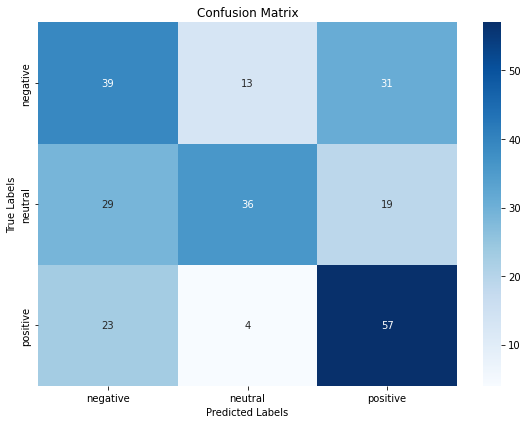

In [67]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()